In [70]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [71]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [72]:
from config import (
    N_CUSTOMERS,
    NUM_WEEKS,
    K,
    DECAY_RATE,
    RECOVERY_RATE,
    COOLDOWN_WINDOW,
    COOLDOWN_PENALTY,
    REGRET_THRESHOLD,
    SEEDS
)

In [73]:
from simulation.simulate_week_for_export import initialize_world,advance_one_week

In [74]:
def run_cooldown_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,
COOLDOWN_PENALTY,REGRET_THRESHOLD):
    df['last_reviewed_week'] = -1
    df.loc[df['reviewed'],'last_reviewed_week'] = 1
    weekly_regret_cooldown= []
    for week in range(2,NUM_WEEKS+1):
        df['adjusted_urgency'] = df['urgency_score']
        recent_mask = ( df['last_reviewed_week'] == week -1 )
        df.loc[recent_mask,'adjusted_urgency'] *= COOLDOWN_PENALTY
        df['reviewed'] = False
        to_review = (
            df.sort_values('adjusted_urgency',ascending=False).head(K).index
        )
        df.loc[to_review,'reviewed'] = True
        df.loc[to_review, 'last_reviewed_week'] = week
        df = advance_one_week(df,DECAY_RATE,RECOVERY_RATE)
        regret_count = ((df['tolerance'] < REGRET_THRESHOLD) & (~df['reviewed'])).sum()
        weekly_regret_cooldown.append(regret_count)

    return sum(weekly_regret_cooldown)

In [75]:
def run_random_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,
REGRET_THRESHOLD):
    weekly_regret_random = []
    for week in range(NUM_WEEKS):
        df['reviewed'] = False
        review_id = np.random.choice(df.index,size=K,replace = False)
        df.loc[review_id,'reviewed'] = True
        df = advance_one_week(df,DECAY_RATE,RECOVERY_RATE)
        regret_count = ((df['tolerance'] < REGRET_THRESHOLD) & (~df['reviewed'])).sum()
        weekly_regret_random.append(regret_count)

    return sum(weekly_regret_random)

In [76]:
def run_urgency_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,
REGRET_THRESHOLD):
    weekly_regret_urgency = []
    for week in range(NUM_WEEKS):
        df['reviewed'] = False
        review_id = (df.sort_values('urgency_score',ascending=False).head(K).index)
        df.loc[review_id,'reviewed'] = True
        df = advance_one_week(df,DECAY_RATE,RECOVERY_RATE)
        regret_count = ((df['tolerance'] < REGRET_THRESHOLD) & (~df['reviewed'])).sum()
        weekly_regret_urgency.append(regret_count)

    return sum(weekly_regret_urgency)

In [77]:
results = []
for seed in SEEDS:
    np.random.seed(seed)
    random.seed(seed)

    # ---- RANDOM POLICY ----
    df = initialize_world()
    regret_random = run_random_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,REGRET_THRESHOLD)
    
    # ---- URGENCY POLICY ----
    df = initialize_world()
    regret_urgency = run_urgency_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,REGRET_THRESHOLD)

    # ---- COOLDOWN POLICY ----
    df = initialize_world()
    regret_cooldown = run_cooldown_policy(df,NUM_WEEKS,K,DECAY_RATE,RECOVERY_RATE,COOLDOWN_PENALTY,REGRET_THRESHOLD)
    
    results.append({
        "seed": seed,
        "random": regret_random,
        "urgency": regret_urgency,
        "cooldown": regret_cooldown
    })


In [78]:
df_result = pd.DataFrame(results)
df_result.head()

,seed,random,urgency,cooldown
0,0,338,348,324
1,1,337,366,338
2,2,337,346,348
3,3,313,464,332
4,4,276,430,340


In [79]:
df_long = df_result.melt(
    id_vars="seed",
    value_vars=["random", "urgency", "cooldown"],
    var_name="policy",
    value_name="regret"
)

In [80]:
summary = (
    df_long
    .groupby("policy")["regret"]
    .agg(["mean", "std"])
    .reset_index()
)

In [81]:
summary.round(2)

,policy,mean,std
0,cooldown,328.97,29.10
1,random,314.00,27.66
2,urgency,384.30,40.06


<Figure size 640x480 with 0 Axes>

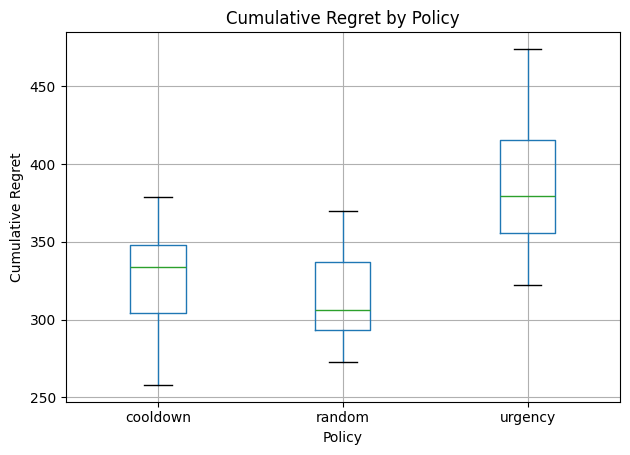

In [83]:
plt.figure()
df_long.boxplot(column="regret", by="policy")
plt.title("Cumulative Regret by Policy")
plt.suptitle("")  
plt.xlabel("Policy")
plt.ylabel("Cumulative Regret")
plt.tight_layout()
plt.show()
